In [1]:
from scGCO import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
# Compare the Cumulative Distribution Function(cdf) of hamming distance with three SV genes sets 
# 

hamming_cut=[0.77, 0.79, 0.76, 0.73, 0.76, 0.7, 0.69, 0.69, 0.72, 0.79, 0.76, 0.78]
for j in [11]:
    unary_scale_factor=100
    label_cost=10
    algorithm='expansion'
    ff = '../../data/Raw_data/MOB-breast-cancer///Rep' + str(j) +  '_MOB_count_matrix-1.tsv'
    locs,data=read_spatial_expression(ff,sep='\t')

    data_norm = normalize_count_cellranger(data)
    print('Rep{}_processing: {}'.format(j,data_norm.shape))

    
    ## upload data
    result_df=read_result_to_dataframe('../../data/MouseOB/scGCO_results/Rep{}_result_df.csv'.format(j))
    print(result_df.shape)

    step2=read_result_to_dataframe('../../data/MouseOB/scGCO_results/Rep{}_pattern_df.csv'.format(j))
    print('Rep{} 2 {}'.format(j,step2.shape))   ### pattern_df
   
    step3=read_result_to_dataframe('../../data/MouseOB/scGCO_results/Rep11_final_df.csv'.format(j))
    df_gco=step3
    print(df_gco.shape)
    scGCO_list = df_gco.index


    de='../../data/MouseOB/spatialDE_results/Rep{}_MOB_results.csv'.format(j)
    df_de = pd.read_csv(de)
    de_list=df_de.g.values

    common = set(scGCO_list).intersection(set(de_list))
    scGCO_only = set(scGCO_list).difference(set(de_list))
    SpatialDE_only = set(de_list).difference(set(scGCO_list ))
    List_df=['scGCO_only','SpatialDE_only','common']

    # ## get tissue mat
    fdr_opt=step2
    tissue_mat,_=generate_cluster_tissue_mat(locs, data_norm, fdr_opt, sf = 30, fixed_k=5)
    
    hamming_cutoff=hamming_cut[j-1]
    ### compare tissue_mat for getting hamming df  
    for listName in List_df:
        geneList=eval(listName)

        _,hamming_df=compare_tissue_mat_hamming_fixed(data_norm, tissue_mat,result_df,geneList,
                                                      similarity_cutoff = hamming_cutoff)
       # hamming_df.to_csv('../../../data/MouseOB/scGCO_results/hamming_df/Rep{}_{}_hamming_df.csv'.format(j,listName))


raw data dim: (267, 16573)
Rep1_processing: (264, 14614)
(12489, 271)
Rep1 2 (421, 271)
(418, 271)
5
[ 94.  94.  43.  87. 130. 134.  81.  42.  86.  55.  82.  29.  42.  74.
  37.]
raw data dim: (280, 15981)
Rep2_processing: (277, 14021)
(11885, 284)
Rep2 2 (329, 284)
(318, 284)
5
[107. 107.  95. 131.  51. 117.  95.  27.  38.  79.  93.  27.  40.  38.]
raw data dim: (269, 16014)
Rep3_processing: (266, 14131)
(11922, 273)
Rep3 2 (350, 273)
(315, 273)
5
[109. 109.  37.  97. 134. 132.  27. 114.  35.  90.  36.  59.  96.  29.
  46.]
raw data dim: (264, 15941)
Rep4_processing: (261, 13898)
(11628, 268)
Rep4 2 (272, 268)
(264, 268)
5
[ 95.  95. 117.  88.  56.  55.  60.  78.  68.  35.  75.  32.  96.  23.]
raw data dim: (267, 15290)
Rep5_processing: (265, 13269)
(10995, 272)
Rep5 2 (153, 272)
(150, 272)
5
[ 97.  97.  91.  52. 122.  54.  51.  74.  86.  43.  38.  74.  36.  74.]
raw data dim: (242, 16251)
Rep6_processing: (239, 15018)
(12315, 246)
Rep6 2 (360, 246)
(352, 246)
5
[ 89.  89. 107.  76.  

In [2]:
def cumcdf(data,num_bin=300):
    counts,bin_edges=np.histogram(data,bins=num_bin)
    cdf=np.cumsum(counts)
    x=bin_edges[1:]
    y=cdf/cdf[-1]
    return x,y

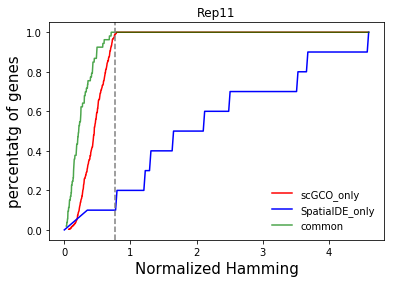

In [3]:
#j=1
List_df=['scGCO_only','SpatialDE_only','common']
nrows=1
ncols=1
 
for j in [11]: 
    
    scgco_hamming=pd.read_csv('../../data/MouseOB/scGCO_results/hamming_df/Rep{}_{}_hamming_df.csv'.format(j,List_df[0]))
    de_hamming=pd.read_csv('../../data/MouseOB/scGCO_results/hamming_df/Rep{}_{}_hamming_df.csv'.format(j,List_df[1])) 
    common_hamming=pd.read_csv('../../data/MouseOB/scGCO_results/hamming_df/Rep{}_{}_hamming_df.csv'.format(j,List_df[2]))
    
    fig,ax=plt.subplots()
    
    cdf_de=cumcdf(de_hamming.hamming.values,num_bin=200)
    cdf_scgco=cumcdf(scgco_hamming.hamming.values,num_bin=200)
    ax.plot(np.append(cdf_scgco[0],cdf_de[0].max()),np.append(cdf_scgco[1],1),c='r',label=List_df[0])

    ax.plot(np.append(0,cdf_de[0]),np.append(0,cdf_de[1]),c='b',label=List_df[1])

    cdf_co=cumcdf(common_hamming.hamming.values,num_bin=200)
    ax.plot(np.append(cdf_co[0],cdf_de[0].max()),np.append(cdf_co[1],1),c='g',label=List_df[2],alpha=0.7)
    ax.set_title('Rep{}'.format(j))
    ax.axvline(0.76,ls='--',c='grey')
    
    plt.xlabel('Normalized Hamming',fontsize=15)
    plt.ylabel('percentatg of genes',fontsize=15)
    plt.legend(frameon=False)

    plt.savefig('../../figures//Suppl_Fig1_Rep{}_hamming_curve.pdf'.format(j))
    plt.show()

### Fig 2c,2d

raw data dim: (262, 16218)
Rep11_processing: (259, 14639)


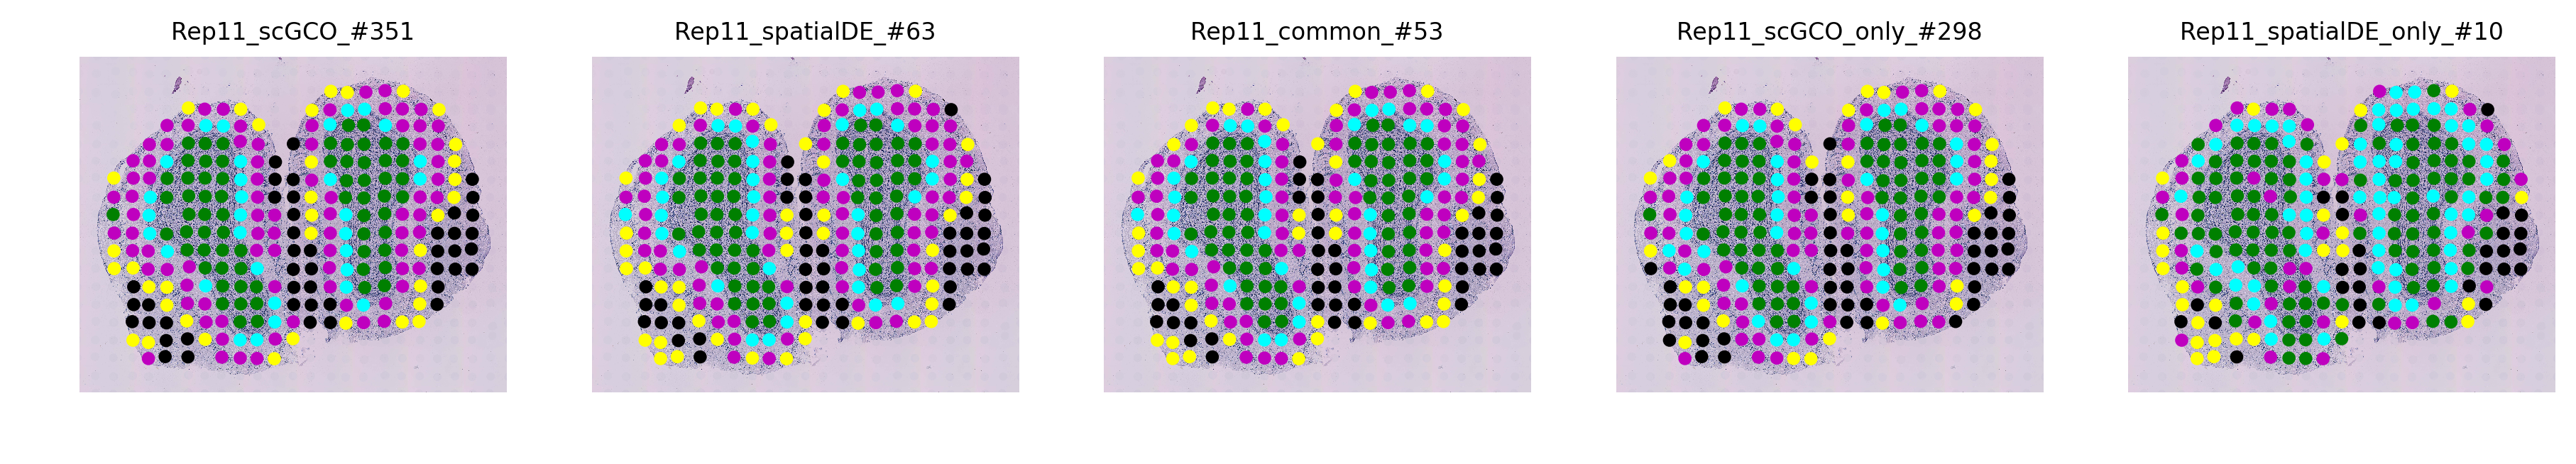

In [4]:
## Tissue_structure---hmrf_labels  11
##
hmrf_df=pd.DataFrame()


j=11
unary_scale_factor=100
label_cost=10
algorithm='expansion'
ff = '../../data/Raw_data/MOB-breast-cancer/Rep11_MOB_count_matrix-1.tsv'
locs,data=read_spatial_expression(ff,sep='\t')

data_norm = normalize_count_cellranger(data)
print('Rep{}_processing: {}'.format(j,data_norm.shape))


scgco=read_result_to_dataframe('../../data/MouseOB/scGCO_results//Rep11_final_df.csv')
scGCO=scgco.index

de='../../data/MouseOB/spatialDE_results/Rep11_MOB_results.csv'
de = pd.read_csv(de)
de=de[de.qval<0.05].query("g!='log_total_count'")
spatialDE=set(de.g.values)&set(data_norm.T.index.values)

common=set(scGCO)&set(spatialDE)&set(data_norm.T.index.values)

scGCO_only=(set(scGCO)-set(spatialDE))&set(data_norm.T.index.values)

spatialDE_only=(set(spatialDE)-set(scGCO))&set(data_norm.T.index.values)

gene_df=['scGCO','spatialDE','common','scGCO_only','spatialDE_only']


nrows=1
ncols=5
fig,ax=plt.subplots(nrows,ncols,figsize=(ncols*3,nrows*3),dpi=(300))   ## dpi=600, 
   ## user can adjust dpi to get high resolution pics
    
for i,geneNames in enumerate(gene_df):
    genelist=eval(geneNames)
    kmeans_labels,hmrf_labels=create_labels(locs,data_norm,genelist,
                                           unary_scale_factor=100,
                                           smooth_factor=10,rs=15)

    image='../../data/Raw_data/HE-MOB-breast-cancer/HE_Rep{}_MOB.jpg'.format(j)

    title='Rep{}_{}_#{}'.format(j,geneNames,len(genelist))  
    if i==0:
        colors=['yellow','cyan','green','k','m']
    if i==1:
        colors=['k','green','yellow','m','cyan']
    if i==2:
        colors=['cyan','k','green','m','yellow']
    if i==3:
        colors=['yellow','cyan','green','k','m'] 
    if i==4:
        colors=['cyan','yellow','m','green','k']
    axes=ax[i]
    subplot_HE_with_labels(locs,hmrf_labels,image,axes,colors,title,s=12)
    axes.axis('off')

plt.savefig('../../figures//Rep11_tissue_structure.pdf'.format(j))
plt.show()
